<a href="https://colab.research.google.com/github/tancredew/ObesityData/blob/main/DSRP_Obesity_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd

url = 'https://raw.githubusercontent.com/tancredew/ObesityData/main/ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(url)
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Primary Question:
Can interpretable supervised learning models (like decision trees or logistic regression) identify key lifestyle features that predict obesity status?

Secondary Question:
Do these predictors differ across subgroups such as age or gender?

Supervised: nearest neighbor, sk learn, svm, linear

Unsupervised: keep simple

Before dropping duplicates: (2087, 17)
After dropping duplicates: (2087, 17)
Class distribution:
 NObeyesdad
Obesity_Type_I         0.168184
Obesity_Type_III       0.155247
Obesity_Type_II        0.142310
Overweight_Level_II    0.138955
Normal_Weight          0.135122
Overweight_Level_I     0.132247
Insufficient_Weight    0.127935
Name: proportion, dtype: float64
Number of potential outliers: 24


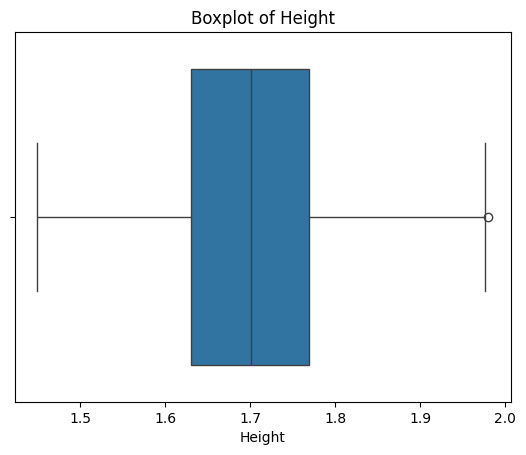

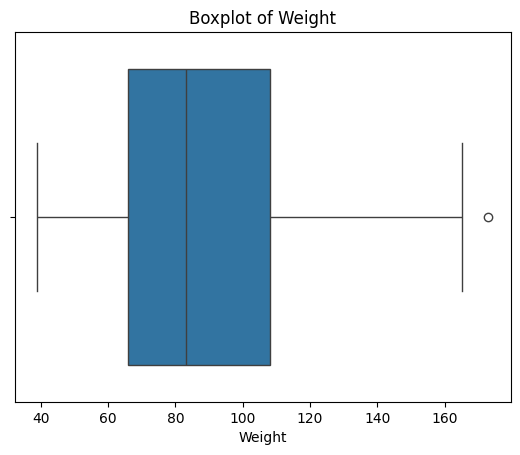

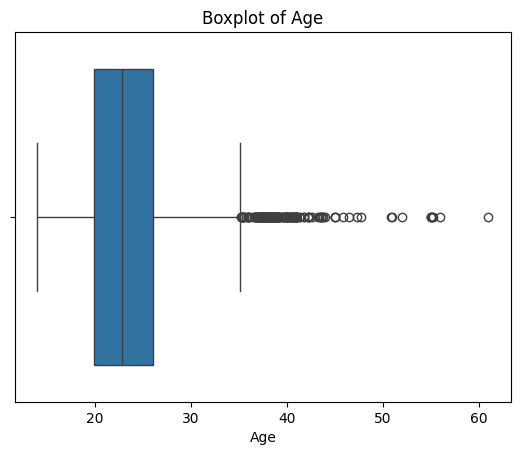

In [10]:
#FIRST SECTION -- PREPROCESSING


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# drop duplicates
print(f"Before dropping duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"After dropping duplicates: {df.shape}")

# separate target and features
target = "NObeyesdad"
X = df.drop(columns=[target])
y = df[target]

# check class balance
print("Class distribution:\n", y.value_counts(normalize=True))

# scale numeric features
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# encode categoricals
X = pd.get_dummies(X, drop_first=True)

# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# outlier inspection
outlier_cols = ["Height", "Weight", "Age"]
z_scores = np.abs(zscore(df[outlier_cols]))
outlier_mask = (z_scores > 3).any(axis=1)

# print outliers
outliers = df[outlier_mask]
print(f"Number of potential outliers: {outliers.shape[0]}")

# boxplots
for col in outlier_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        53
      Normal_Weight       0.84      0.81      0.82        57
     Obesity_Type_I       0.92      0.93      0.92        70
    Obesity_Type_II       0.94      0.98      0.96        60
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.80      0.80      0.80        55
Overweight_Level_II       0.83      0.74      0.78        58

           accuracy                           0.89       418
          macro avg       0.89      0.89      0.89       418
       weighted avg       0.89      0.89      0.89       418



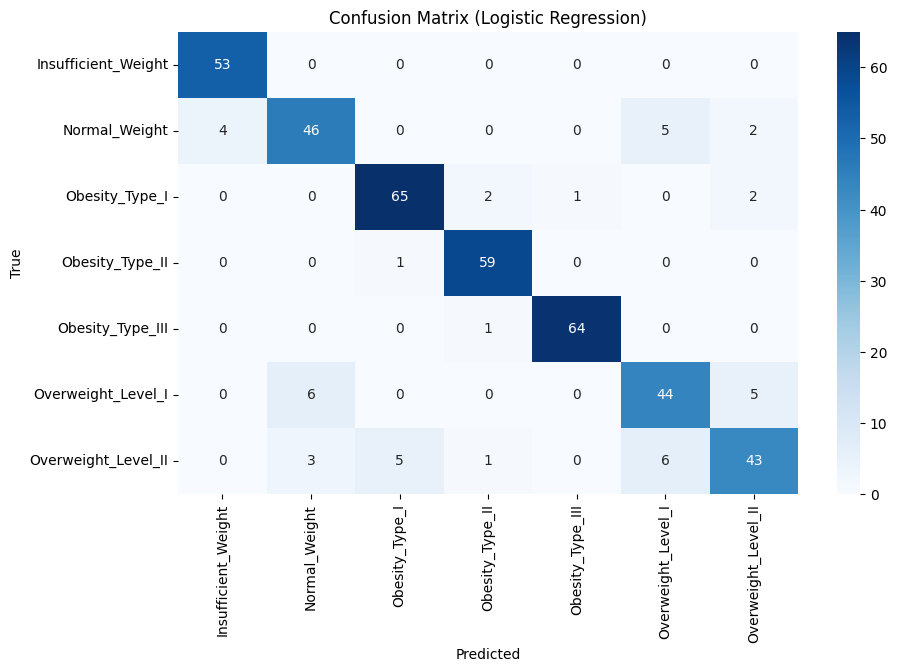

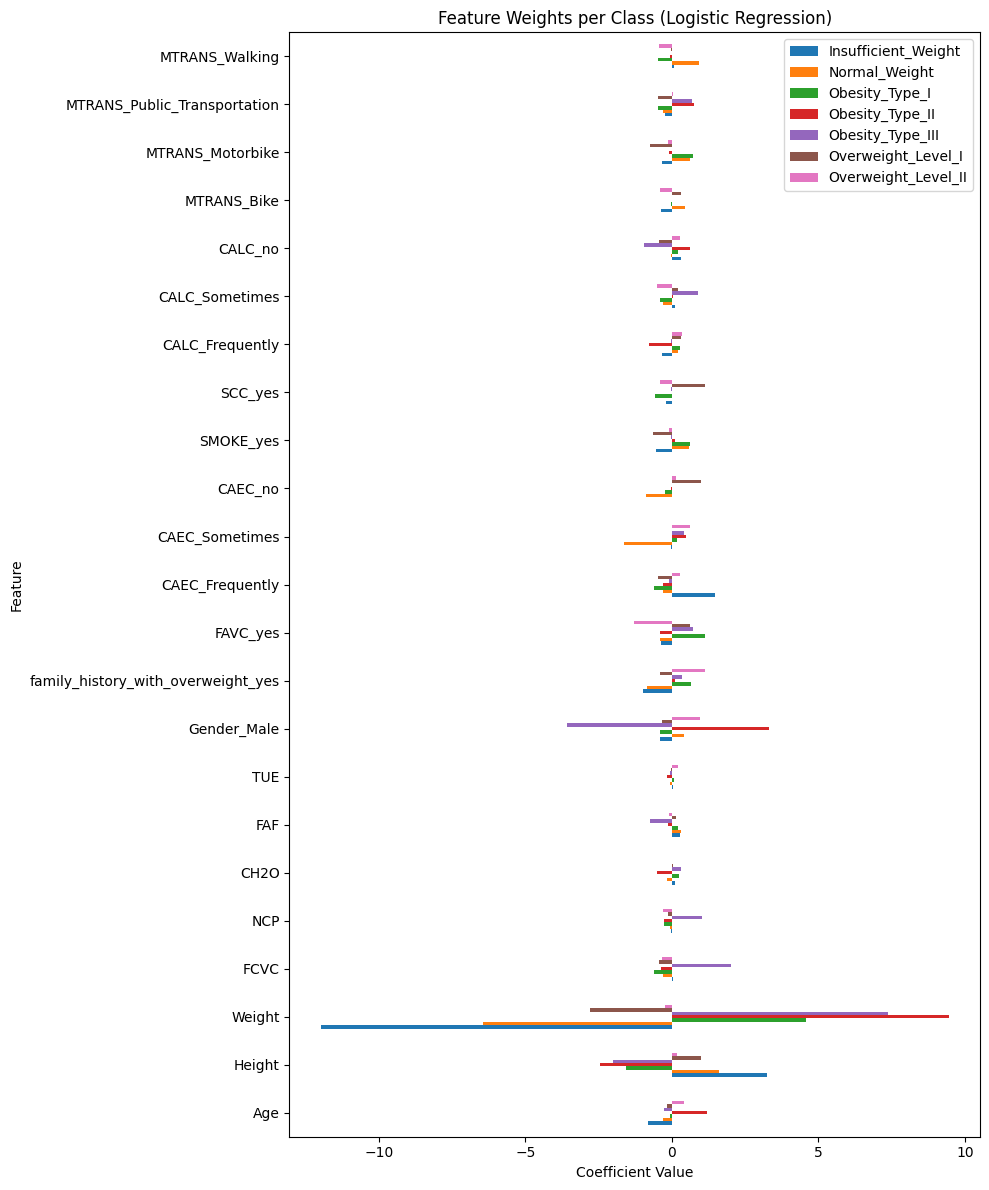

In [11]:
#SECOND SECTION -- LINEAR REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# train logistic regression
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

# evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# feature importance
coefs = pd.DataFrame(log_reg.coef_, columns=X.columns, index=log_reg.classes_)
coefs.T.plot(kind='barh', figsize=(10, 12), legend=True)
plt.title("Feature Weights per Class (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Decision Tree Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.94        53
      Normal_Weight       0.86      0.65      0.74        57
     Obesity_Type_I       0.84      0.61      0.71        70
    Obesity_Type_II       0.84      0.98      0.91        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.60      0.53      0.56        55
Overweight_Level_II       0.51      0.76      0.61        58

           accuracy                           0.78       418
          macro avg       0.80      0.78      0.78       418
       weighted avg       0.80      0.78      0.78       418



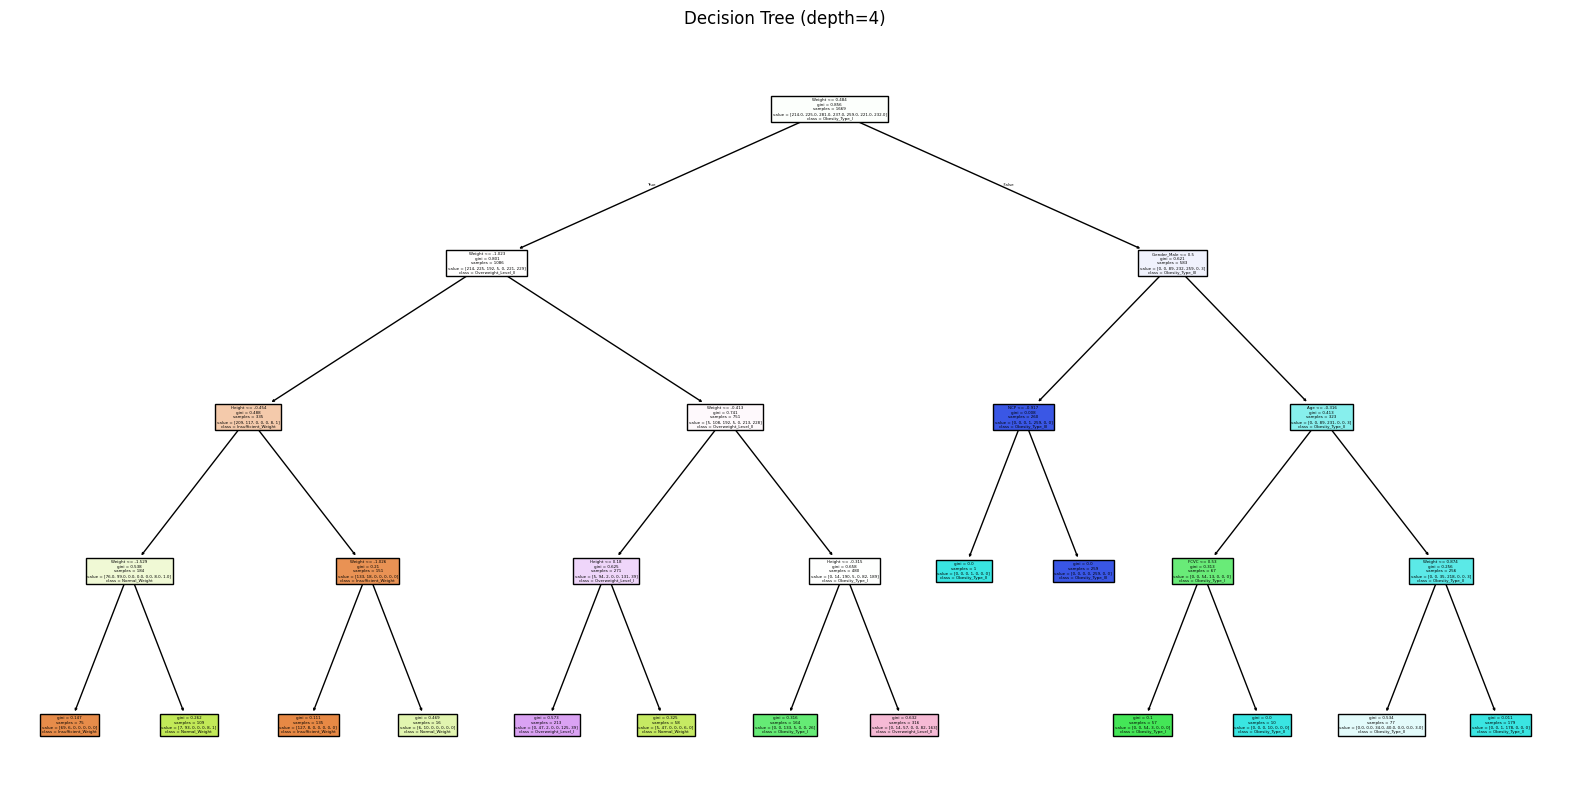

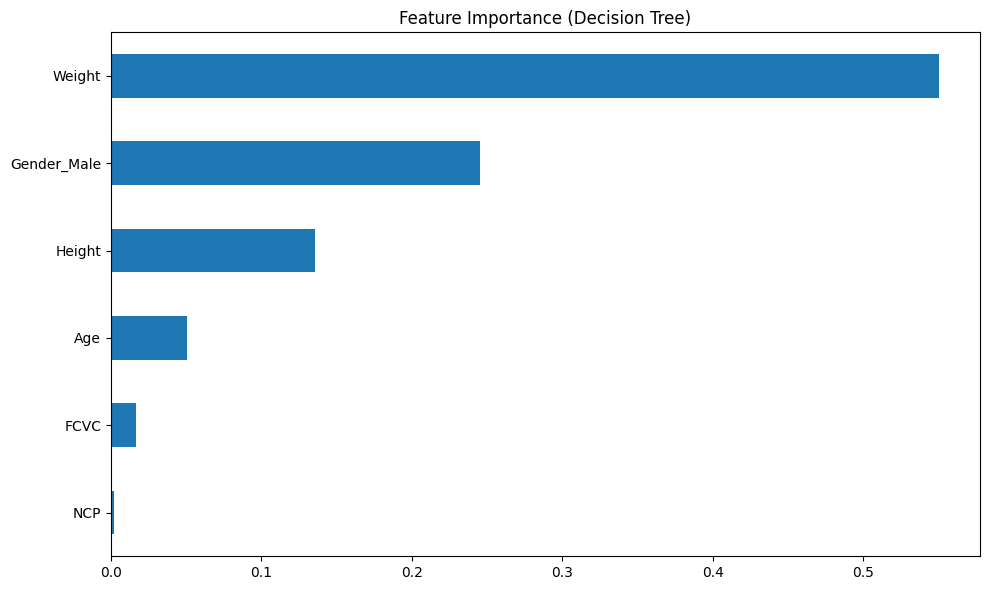

In [12]:
#THIRD SECTION -- DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree

# train decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# predict
y_pred_tree = tree.predict(X_test)

# evaluate
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_tree))

# plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=tree.classes_)
plt.title("Decision Tree (depth=4)")
plt.show()

# feature importance
importances = pd.Series(tree.feature_importances_, index=X.columns)
importances = importances[importances > 0].sort_values()
importances.plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance (Decision Tree)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


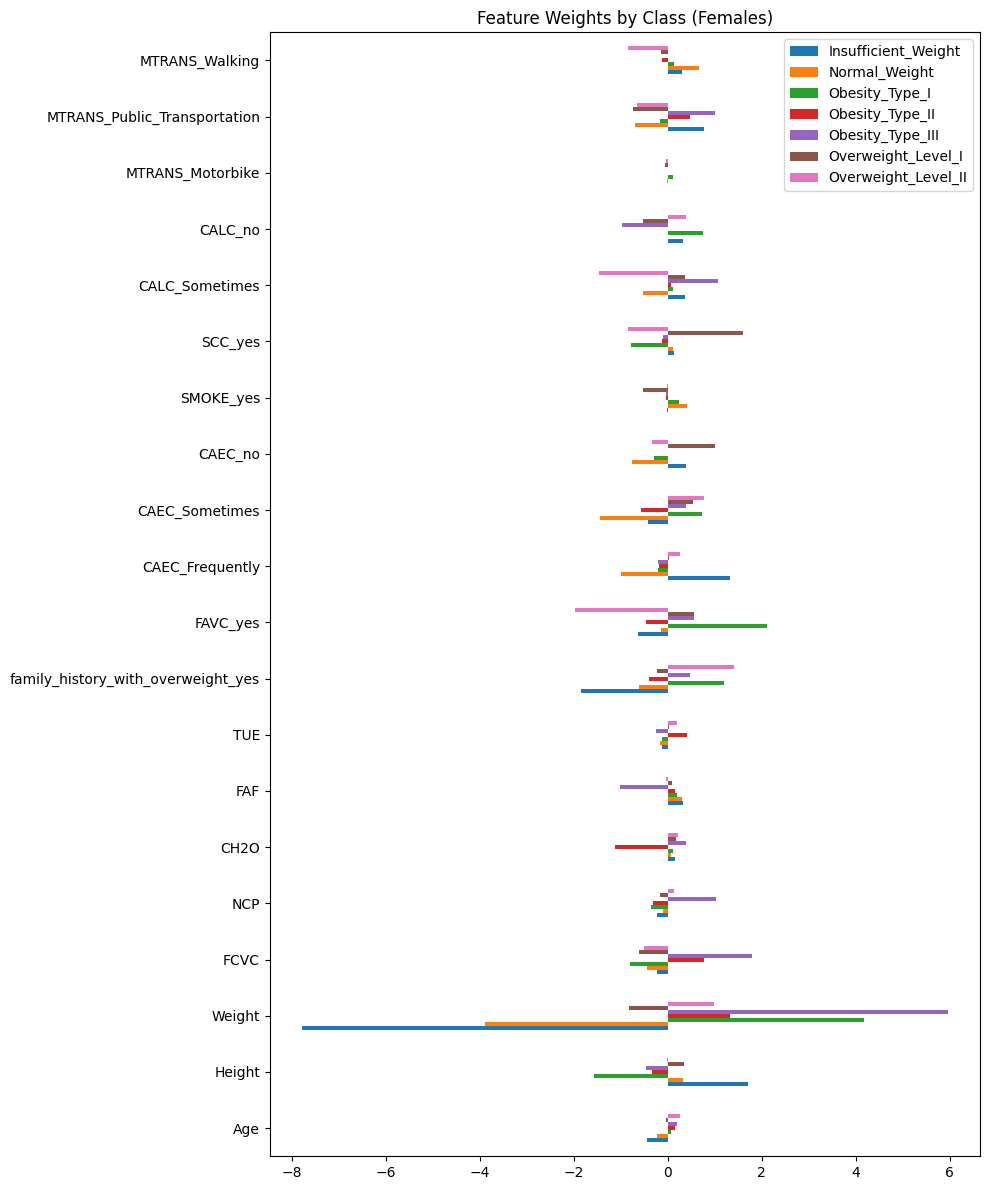

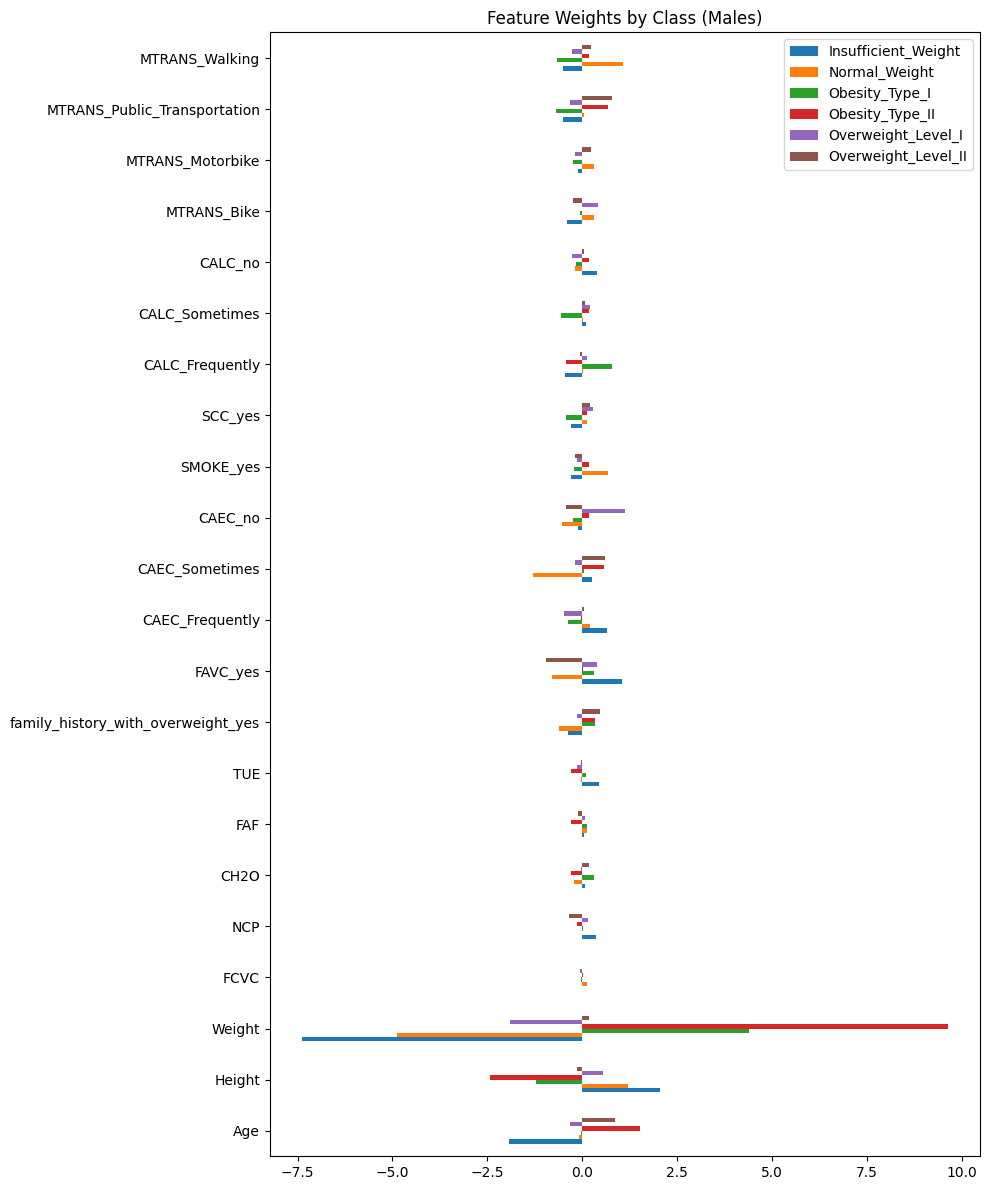

In [14]:
#SECTION 4 -- SUBGROUP ANALYSIS BY GENDER

# split by gender
df_female = df[df["Gender"] == "Female"]
df_male = df[df["Gender"] == "Male"]

# drop Gender from features
X_female = df_female.drop(columns=["NObeyesdad", "Gender"])
X_male = df_male.drop(columns=["NObeyesdad", "Gender"])
y_female = df_female["NObeyesdad"]
y_male = df_male["NObeyesdad"]

# scale + encode
X_female = pd.get_dummies(X_female, drop_first=True)
X_male = pd.get_dummies(X_male, drop_first=True)
scaler = StandardScaler()
X_female[numerical_cols] = scaler.fit_transform(X_female[numerical_cols])
X_male[numerical_cols] = scaler.fit_transform(X_male[numerical_cols])

# drop rare classes in y_male (it caused a bunch of errors because the classes were too small)
class_counts = y_male.value_counts()
valid_classes = class_counts[class_counts >= 2].index
mask = y_male.isin(valid_classes)
X_male = X_male[mask]
y_male = y_male[mask]

# stratified split (now safe)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_male, y_male, stratify=y_male, test_size=0.2, random_state=42
)

# stratified train/test split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_female, y_female, stratify=y_female, test_size=0.2, random_state=42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_male, y_male, stratify=y_male, test_size=0.2, random_state=42)

# train separate models
log_female = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_female.fit(Xf_train, yf_train)

log_male = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_male.fit(Xm_train, ym_train)

# plot feature weights
female_coefs = pd.DataFrame(log_female.coef_, columns=Xf_train.columns, index=log_female.classes_)
male_coefs = pd.DataFrame(log_male.coef_, columns=Xm_train.columns, index=log_male.classes_)

female_coefs.T.plot(kind="barh", figsize=(10, 12), title="Feature Weights by Class (Females)")
plt.tight_layout()
plt.show()

male_coefs.T.plot(kind="barh", figsize=(10, 12), title="Feature Weights by Class (Males)")
plt.tight_layout()
plt.show()
